# Draft 1 - Figure 1

__Brainstormed Description:__  

_Maps Regional (IPCC) and Spatial (5x5deg) of a. Naive ToE, b. Strict ToE, and c. Delay (Strict minus Naive)_

So I will need to work with both the IPCC regional and 5x5 degree spatial data. This will be similar to figure 4 as well.

### Load functions and packages

In [1]:
import sys,warnings
# Add common resources folder to path
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/internalvar-vs-obsunc/')
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/internalvar-vs-obsunc/Common/')

from imports import (
    np, xr, plt, sns, os,
    glob, dask, gridspec,
    mpl,copy
    )

from functions import to_png

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import regionmask

import cartopy.crs as ccrs
import matplotlib.patheffects as pe

from functions import sp_map

In [3]:
def compute_tte(obs_trends,pic_trends):
    '''
    General function comparing the observed trends with the PIC trends to determine TTE.
    '''
    
    _tte_bool = obs_trends > pic_trends
    _tte      = 1960 + _tte_bool.duration.where(~_tte_bool).max(dim='duration')
    _tte      = _tte.where(_tte!=1960+obs_trends.duration.max(),np.nan) # Mask the unemerged regions
    _tte      = _tte.drop(['percentile'])
    
    return _tte

## Spatial (5x5 deg.) Data

### Load processed trend data

#### Models

In [4]:
# I need to go from the CAM output variables to the CMOR/CMIP standard names.
pic_tseries_dir = '/glade/work/jonahshaw/trend_uncertainty/nathan/CMIP6_PIC/'
cesm1_dir       = 'CESM1/'
mpi_dir         = 'MPI-GE/'
canesm2_dir     = 'CanESM2/'
esm2m_dir       = 'ESM2M/'

cesm1_cmor_var_dict = {'ts':'TS','tas':'TREFHT','psl':'PSL'}

Take percentiles from PI-Control Runs of models

In [5]:
cesm1_spatial_trends_filepath   = glob.glob('%s/%s/*5x5degSpatialTrends.Percentiles*.nc' % (pic_tseries_dir,cesm1_dir))
mpi_spatial_trends_filepath     = glob.glob('%s/%s/*5x5degSpatialTrends.Percentiles*.nc' % (pic_tseries_dir,mpi_dir))
canesm2_spatial_trends_filepath = glob.glob('%s/%s/*5x5degSpatialTrends.Percentiles*.nc' % (pic_tseries_dir,canesm2_dir))
esm2m_spatial_trends_filepath   = glob.glob('%s/%s/*5x5degSpatialTrends.Percentiles*.nc' % (pic_tseries_dir,esm2m_dir))

In [6]:
cesm1_regional_trends_filepath   = glob.glob('%s/%s/*.trends.Percentiles*.nc' % (pic_tseries_dir,cesm1_dir))
mpi_regional_trends_filepath     = glob.glob('%s/%s/*.trends.Percentiles*.nc' % (pic_tseries_dir,mpi_dir))
canesm2_regional_trends_filepath = glob.glob('%s/%s/*.trends.Percentiles*.nc' % (pic_tseries_dir,canesm2_dir))
esm2m_regional_trends_filepath   = glob.glob('%s/%s/*.trends.Percentiles*.nc' % (pic_tseries_dir,esm2m_dir))

Load the trend data.

In [7]:
cesm1_pic_spatial_trends_all   = xr.open_dataarray(*cesm1_spatial_trends_filepath)

mpi_pic_spatial_trends_all     = xr.open_dataarray(*mpi_spatial_trends_filepath)

canesm2_pic_spatial_trends_all = xr.open_dataarray(*canesm2_spatial_trends_filepath)

esm2m_pic_spatial_trends_all   = xr.open_dataarray(*esm2m_spatial_trends_filepath)

In [8]:
cesm1_pic_regional_trends_all   = xr.open_dataarray(*cesm1_regional_trends_filepath)

mpi_pic_regional_trends_all     = xr.open_dataarray(*mpi_regional_trends_filepath)

canesm2_pic_regional_trends_all = xr.open_dataarray(*canesm2_regional_trends_filepath)

esm2m_pic_regional_trends_all   = xr.open_dataarray(*esm2m_regional_trends_filepath)

#### Observations

And the OBS-LE is effectively used as a model so I just want the percentiles.

In [16]:
obs_tseries_dir = '/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/'
gistemp_5x5_dir = 'GISTEMP_5x5/'
gistemp_2x2_dir = 'GISTEMP_2x2/'
gistemp_2x2_5x5_dir = 'GISTEMP_2x2/20240217_5x5remap'
hadcrut5_dir    = 'HadCRUT5/'
obsle_dir       = 'mckinnon_OLENS/'

In [17]:
gistemp_tas_var = 'tempAnom'
hadcrut5_tas_var = 'tas'
obsle_tas_var    = 'tas'

In [11]:
# gistemp_5x5_spatial_trends_filepath  = glob.glob('%s/%s/*5x5degSpatialTrends.??????-??????.nc' % (obs_tseries_dir,gistemp_5x5_dir))
gistemp_2x2_5x5_spatial_trends_filepath  = glob.glob('%s/%s/*5x5degSpatialTrends.??????-??????.nc' % (obs_tseries_dir,gistemp_2x2_5x5_dir))
hadcrut5_spatial_trends_filepath     = glob.glob('%s/%s/*5x5degSpatialTrends.??????-??????.nc' % (obs_tseries_dir,hadcrut5_dir))
obsle_spatial_trends_filepath        = glob.glob('%s/%s/*.5x5*.Percentiles*.nc' % (obs_tseries_dir,obsle_dir))

In [22]:
# gistemp_5x5_regional_trends_filepath  = glob.glob('%s/%s/*trends.196001-202012*.nc' % (obs_tseries_dir,gistemp_5x5_dir))
gistemp_2x2_regional_trends_filepath  = glob.glob('%s/%s/*trends.196001-202012*.nc' % (obs_tseries_dir,gistemp_2x2_dir))
hadcrut5_regional_trends_filepath     = glob.glob('%s/%s/*trends.196001-202012*.nc' % (obs_tseries_dir,hadcrut5_dir))
obsle_regional_trends_filepath        = glob.glob('%s/%s/*region*.Percentiles*.nc' % (obs_tseries_dir,obsle_dir))

Load the trend data

In [23]:
gistemp_5x5_spatial_trends_all  = xr.open_mfdataset(gistemp_2x2_5x5_spatial_trends_filepath).drop('startyear')['tas'].chunk({'record': -1})
hadcrut5_spatial_trends_all     = xr.open_mfdataset(hadcrut5_spatial_trends_filepath).drop('startyear').rename({'longitude':'lon','latitude':'lat','realization':'record'})['tas'].chunk({'record': -1})
gistemp_5x5_spatial_trends_all['record'] = gistemp_5x5_spatial_trends_all['record'] - 2 # Shift back to 1
obsle_spatial_trends_all        = xr.open_dataarray(*obsle_spatial_trends_filepath)

In [24]:
gistemp_regional_trends_all  = xr.open_dataarray(*gistemp_2x2_regional_trends_filepath).sel(startyear=1960).drop('startyear')
hadcrut5_regional_trends_all     = xr.open_dataarray(*hadcrut5_regional_trends_filepath).sel(startyear=1960).drop('startyear').rename({'realization':'record'})
obsle_regional_trends_all        = xr.open_dataarray(*obsle_regional_trends_filepath)

### Compute TTE generally

In [29]:
obs_spatial_trend_dict  = {'GISTEMP_5x5':gistemp_5x5_spatial_trends_all,
                           'HadCRUT':hadcrut5_spatial_trends_all}
obs_regional_trend_dict = {'GISTEMP_5x5':gistemp_regional_trends_all,
                           'HadCRUT':hadcrut5_regional_trends_all}
obs_trend_dict          = {'spatial':obs_spatial_trend_dict,
                           'regional':obs_regional_trend_dict}

model_spatial_trend_dict = {'CESM1':cesm1_pic_spatial_trends_all,
                            'MPI':mpi_pic_spatial_trends_all,
                            'CanESM2':canesm2_pic_spatial_trends_all,
                            'ESM2M':esm2m_pic_spatial_trends_all,
                            'OBS-LE':obsle_spatial_trends_all,
                           }

model_regional_trend_dict = {'CESM1':cesm1_pic_regional_trends_all,
                             'MPI':mpi_pic_regional_trends_all,
                             'CanESM2':canesm2_pic_regional_trends_all,
                             'ESM2M':esm2m_pic_regional_trends_all,
                             'OBS-LE':obsle_regional_trends_all,
                            }
                                         
model_trend_dict          = {'spatial':model_spatial_trend_dict,
                             'regional':model_regional_trend_dict}

Compute the TTE for each ensemble member separately.

In [30]:
%%time 

spatial_box = []
regional_box = []

# Iterate over regional vs. spatial
for _location_type in list(obs_trend_dict.keys()):
    
    print(_location_type)
    _box = spatial_box if (_location_type == 'spatial') else regional_box
    location_box = []
    
    _allobs_trends = obs_trend_dict[_location_type]
    _allmodel_trends = model_trend_dict[_location_type]
    
    for _obs_product in list(_allobs_trends.keys()):
        print(_obs_product)
        obs_box = []
        
        _obs_trends = _allobs_trends[_obs_product]
        
        for _model_product in list(_allmodel_trends.keys()):
            print(_model_product)
            _model_trends = _allmodel_trends[_model_product]
            
            # Compute ToE of the median trend (more consistent with using the 50%ile trend for mean)
            _mean_toe = compute_tte(obs_trends=_obs_trends.median(dim='record'),
                                    pic_trends=_model_trends.sel(percentile=97.5))

            # Compute ToE for each ensemble member and take the 95th percentile
            _strict_toe = compute_tte(obs_trends=_obs_trends,
                                      pic_trends=_model_trends.sel(percentile=97.5))

            # Switch nans to infs in order to compute the strict ToE correctly. Then switch infs back to nans in order to mask correctly.
            _strict_toe = _strict_toe.where(~np.isnan(_strict_toe),np.inf).quantile(q=0.95,dim='record',interpolation='nearest')
            _strict_toe = _strict_toe.where(~np.isinf(_strict_toe),np.nan)
            
            # Compute the delay and conditional delay mask:
            _delay_toe = _strict_toe - _mean_toe # Compute the delay
            _delay_undef_region = np.bitwise_and(np.isnan(_strict_toe), ~np.isnan(_mean_toe)) # Mask for where tas is emerged in the mean but not the "strict" sense.
            _delay_toe = xr.where(_delay_undef_region,2020 - _mean_toe,_delay_toe) # Apply the conditional mask

            _toes = xr.concat([_mean_toe.assign_coords({'metric':'mean'},).expand_dims(['metric'],axis=[-1]),
                               _strict_toe.assign_coords({'metric':'strict'},).expand_dims(['metric'],axis=[-1]),
                               _delay_toe.assign_coords({'metric':'delay'},).expand_dims(['metric'],axis=[-1]),
                               _delay_undef_region.assign_coords({'metric':'delay_mask'},).expand_dims(['metric'],axis=[-1]),
                              ],
                              dim='metric',
                             )            
                              
            obs_box.append(_toes.assign_coords({'model':_model_product},).expand_dims(['model'],axis=[-1]))
                        
        location_box.append(xr.concat(obs_box,dim='model').assign_coords({'obs':_obs_product},).expand_dims(['obs'],axis=[-1]))
    _box.append(xr.concat(location_box,dim='obs').compute())
    
spatial_masked_da = spatial_box[0]

spatial
GISTEMP_5x5
CESM1
MPI
CanESM2
ESM2M
OBS-LE
HadCRUT
CESM1
MPI
CanESM2
ESM2M
OBS-LE


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


regional
GISTEMP_5x5
CESM1
MPI
CanESM2
ESM2M
OBS-LE
HadCRUT
CESM1
MPI
CanESM2
ESM2M
OBS-LE
CPU times: user 8.04 s, sys: 1.2 s, total: 9.24 s
Wall time: 10.8 s


### Plot with IPCC Regions

Need to convert the IPCC Region Indexing to lat-lon coordinates in order to plot spatially.

In [31]:
%%time

# User set-up
data  = regional_box[0]

mean_data   = data.sel(metric='mean')
strict_data = data.sel(metric='strict')
delay_data  = data.sel(metric='delay')
delay_mask  = data.sel(metric='delay_mask')

# ipcc_ar6_regions_land   = regionmask.defined_regions.ar6.land
ipcc_ar6_regions_all    = regionmask.defined_regions.ar6.all

# unc_mask = ipcc_ar6_regions_land.mask(np.arange(-179.5, 180, 0.5),np.arange(-89.5, 90, 0.5),)
unc_mask = ipcc_ar6_regions_all.mask(np.arange(-179.5, 180, 0.5),np.arange(-89.5, 90, 0.5),)

# CESM1-GISTEMP 5x5
_mean_mask   = unc_mask.copy()
_strict_mask = unc_mask.copy()
_delay_data_mask  = unc_mask.copy()
_delay_mask_mask  = unc_mask.copy()

del unc_mask

offset = -1000 # Need an offset or it may confuse regions with the delays (delays are on [0,40] similar to the region indices)
for i in ipcc_ar6_regions_all.numbers:
    
    _mean_mask   = xr.where(_mean_mask==i,mean_data.sel(RegionIndex=i)+offset,_mean_mask)
    _strict_mask = xr.where(_strict_mask==i,strict_data.sel(RegionIndex=i)+offset,_strict_mask)
    _delay_data_mask  = xr.where(_delay_data_mask==i,delay_data.sel(RegionIndex=i)+offset,_delay_data_mask)
    _delay_mask_mask  = xr.where(_delay_mask_mask==i,delay_mask.sel(RegionIndex=i)+offset,_delay_mask_mask)

regional_masked_da = xr.concat([_mean_mask,_strict_mask,_delay_data_mask,_delay_mask_mask],dim='metric')-offset

CPU times: user 2.31 s, sys: 106 ms, total: 2.41 s
Wall time: 3.65 s


In [32]:
# Function for the regional figures.
def plot_regional_toe_and_delay(data,obs,model,title=True):
    
    data_subset     = data.sel(obs=obs,model=model)
    data_mean       = data_subset.sel(metric='mean')
    data_strict     = data_subset.sel(metric='strict')
    data_delay      = data_subset.sel(metric='delay')
    data_delay_mask = data_subset.sel(metric='delay_mask')

    fig,axs = sp_map(1,3,projection=ccrs.Robinson(),figsize=(21,6))
    axs = axs.flat

    cax1 = plt.axes([0.18, 0.22, 0.40, 0.03])
    cax2 = plt.axes([0.675, 0.22, 0.20, 0.03])

    ToE_cmap = copy.copy(mpl.cm.viridis)
    ToE_cmap.set_over('white')
    
    delay_cmap = sns.light_palette('red',n_colors=10,reverse=False,as_cmap=True)
    delay_cmap.set_over('magenta')
    delay_levels = list(np.linspace(0,20,5))
    
    masks  = [data_mean,data_strict,data_delay]
    titles = ['Mean ToE','Strict ToE','Observational delay']
    levels = [np.linspace(1960,2020,13),np.linspace(1960,2020,13),delay_levels] 
    cmaps  = [ToE_cmap,ToE_cmap,delay_cmap]
    extend = ['max','max','max']

    plt.subplots_adjust(wspace=0.05)

    ims = [] 
    for _ax,_mask,_label,_levels,_cmap,_extend in zip(axs,masks,titles,levels,cmaps,extend):

        im = _ax.contourf(_mask.lon,_mask.lat,_mask, 60,
                          transform=ccrs.PlateCarree(),
                          levels=_levels,
                          cmap=_cmap,
                          extend=_extend,
                         )

        _ax.coastlines()
        _ax.set_global()
        _ax.set_title(_label,fontsize=16)

        ims.append(im)

    _ = axs[2].contourf(data_delay_mask.lon,data_delay_mask.lat,data_delay_mask, levels=[0,0.5,2], colors='none',
                        transform=ccrs.PlateCarree(),
                        hatches=[None,'\\\\',],
                        extend='max',
                       )

    grey = axs[2].contourf(data_delay.lon,data_delay.lat,np.isnan(data_delay),
                           transform=ccrs.PlateCarree(),
                           extend='max',colors=['none','gray'],levels=[0,0.5,1.5],
                          )

    cbar1 = fig.colorbar(ims[0],orientation='horizontal',
                         ticks=np.linspace(1960,2020,13),
                         cax=cax1,
                        )

    cbar2 = fig.colorbar(ims[2],orientation='horizontal',
                         ticks=np.linspace(0,20,5), # delay_levels, 
                         cax=cax2,
                        )

    cbar1.ax.tick_params(labelsize=12) 
    cbar2.ax.tick_params(labelsize=12)
    
    if title:
        fig.suptitle('IPCC Region Emergence: %s-%s' % (model,obs),fontsize=20,y=0.88)
    
    return fig

It works.

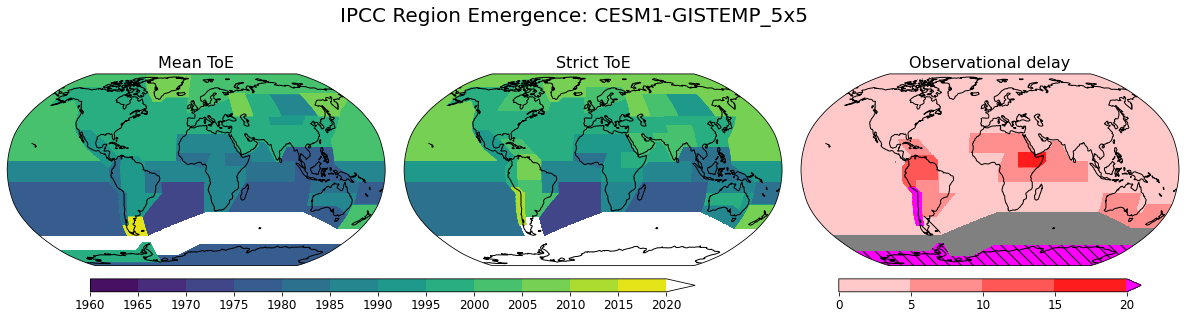

In [33]:
out_fig = plot_regional_toe_and_delay(regional_masked_da,obs='GISTEMP_5x5',model='CESM1')

Create a bunch of figures.

CPU times: user 1min 1s, sys: 455 ms, total: 1min 2s
Wall time: 1min 6s


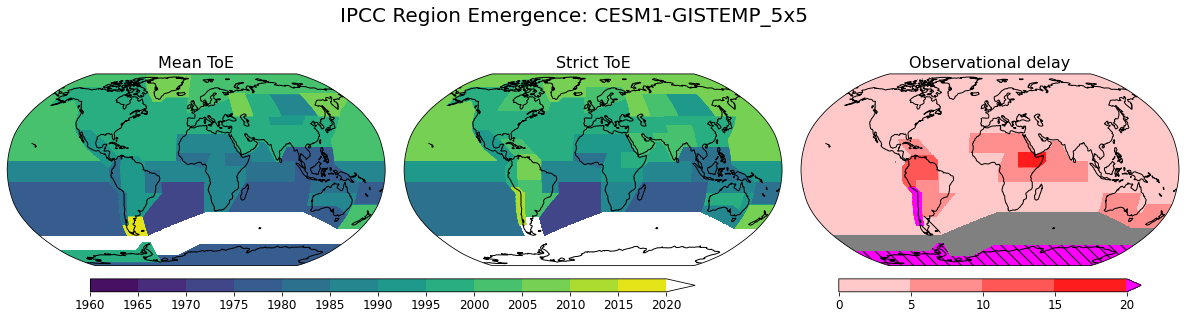

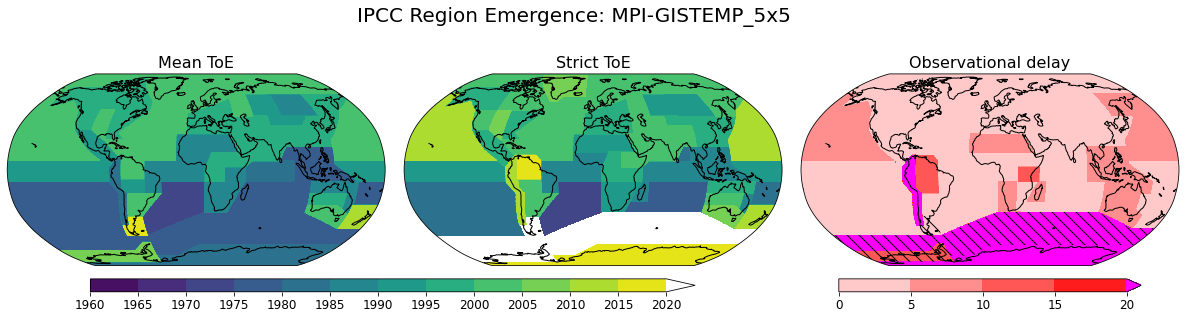

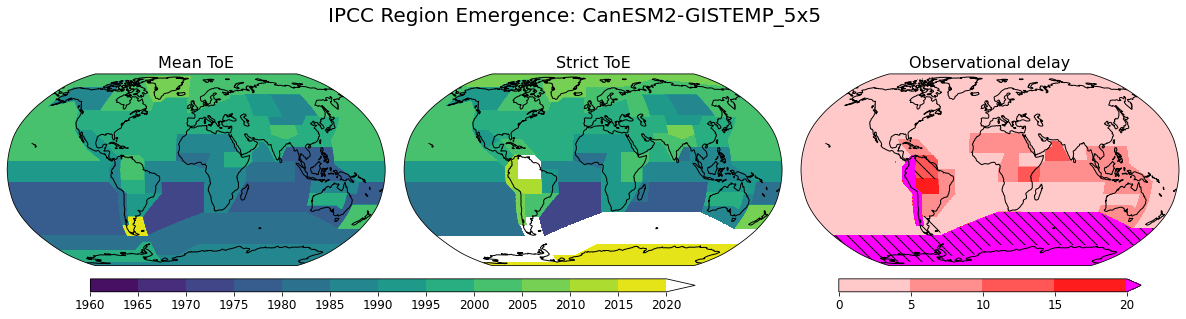

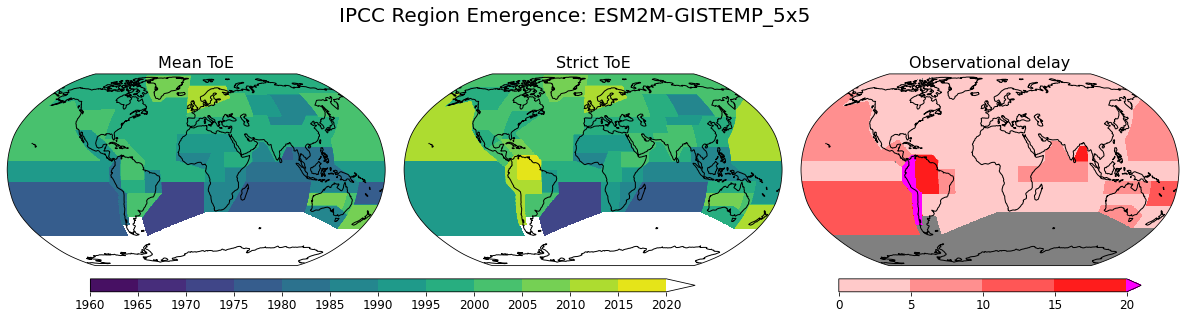

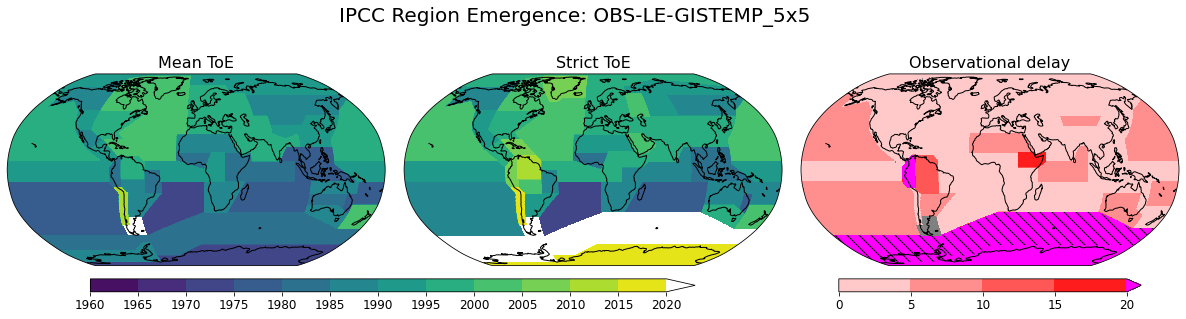

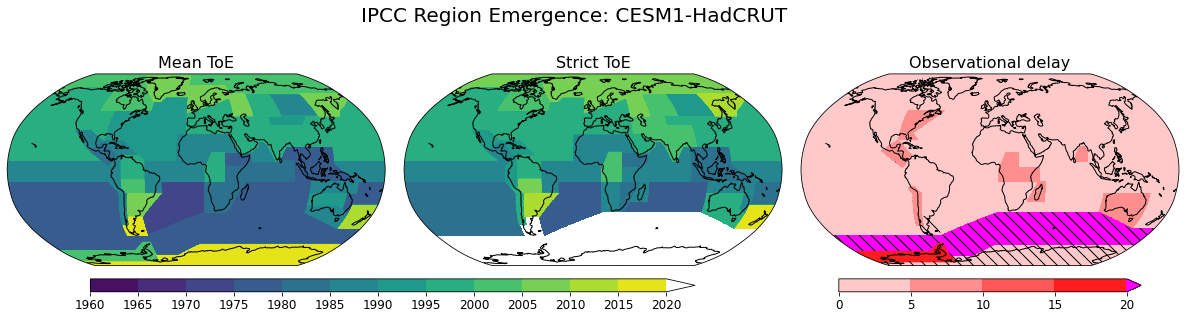

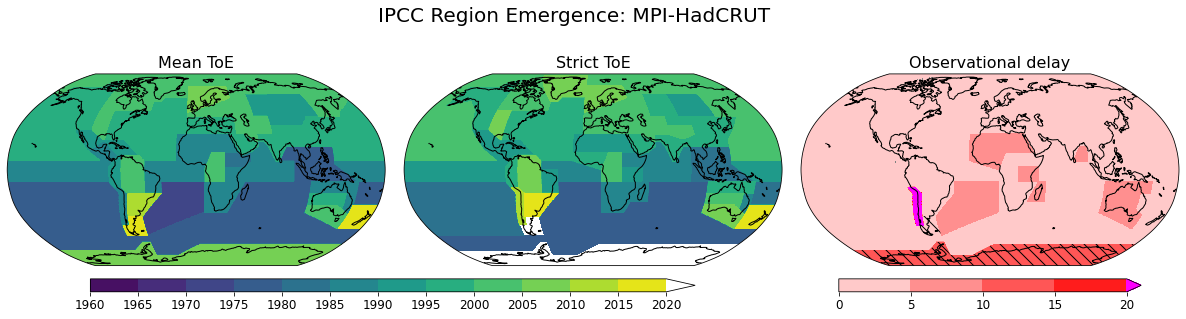

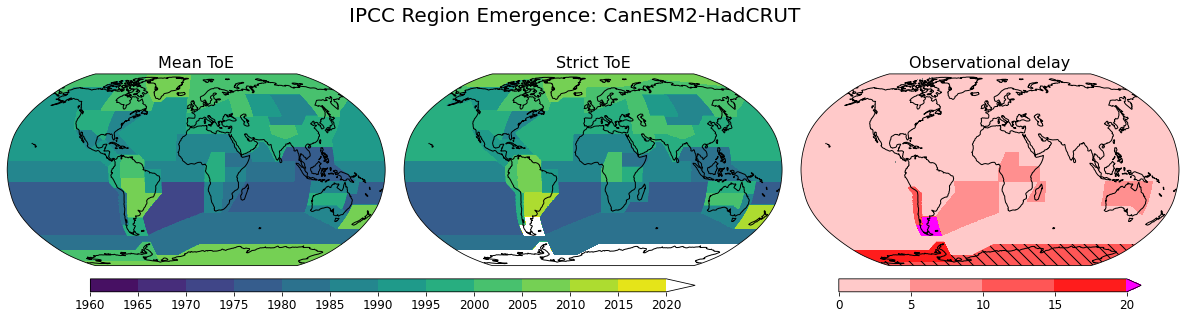

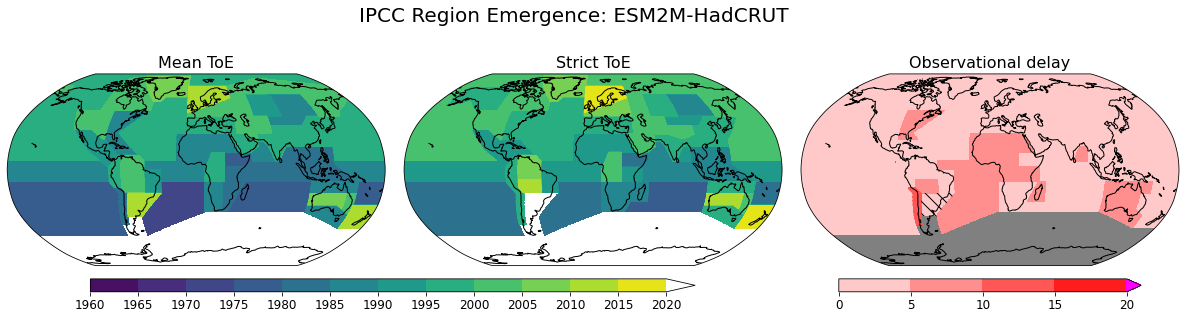

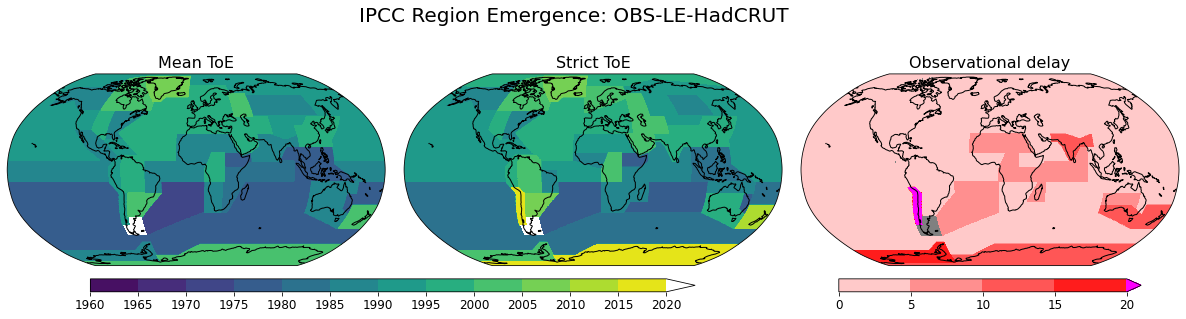

In [34]:
%%time

for _obs in regional_masked_da.obs:
        
    for _model in regional_masked_da.model:
        
        out_fig = plot_regional_toe_and_delay(regional_masked_da,obs=_obs.values,model=_model.values)
        
        to_png(file=out_fig,filename='draft2_ToE_regionalmap_%s_%s' % (_obs.values,_model.values),dpi=300,ext='png',bbox_inches='tight')

Agreement on the west coast of S. America, Australia, and Antarctica, Southern Ocean.

### Plot with Spatial Data

In [36]:
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

In [37]:
def plot_spatial_toe_and_delay(data,obs,model,title=True):

    data_subset = data.sel(obs=obs,model=model)
    mean_data   = data_subset.sel(metric='mean')
    strict_data = data_subset.sel(metric='strict')
    delay_data  = data_subset.sel(metric='delay')
    delay_mask  = data_subset.sel(metric='delay_mask')

    fig,axs = sp_map(1,3,projection=ccrs.Robinson(),figsize=(21,6))
    axs = axs.flat

    cax1 = plt.axes([0.175, 0.22, 0.40, 0.03])
    cax2 = plt.axes([0.685, 0.22, 0.20, 0.03])

    ToE_cmap = copy.copy(mpl.cm.viridis)
    ToE_cmap.set_over('white')
    
    delay_cmap = sns.light_palette('red',n_colors=10,reverse=False,as_cmap=True)
    delay_cmap.set_over('magenta')
    delay_cmap.colorbar_extend = True
    delay_levels = list(np.linspace(0,20,5))

    masks  = [mean_data,strict_data,delay_data]
    titles = ['Mean ToE','Strict ToE','Observational delay']
    levels = [np.linspace(1960,2020,13),np.linspace(1960,2020,13),delay_levels] 
    cmaps = [ToE_cmap,ToE_cmap,delay_cmap]

    plt.subplots_adjust(wspace=0.05)
    
    ims = [] 
    for _ax,_mask,_label,_levels,_cmap in zip(axs,masks,titles,levels,cmaps):

        _norm = BoundaryNorm(_levels, ncolors=_cmap.N, clip=False)

        im = _ax.pcolormesh(_mask.lon,_mask.lat,_mask,
                           transform=ccrs.PlateCarree(),
                           cmap=_cmap,
                           norm=_norm, 
                           )

        _ax.coastlines()
        _ax.set_global()
        _ax.set_title(_label,fontsize=16)

        ims.append(im)

    _ = axs[2].contourf(delay_mask.lon,delay_mask.lat,delay_mask, levels=[0,0.5,2], colors='none',
                        transform=ccrs.PlateCarree(),
                        hatches=[None,'\\\\',],
                        extend='max',
                       )

    grey = axs[2].contourf(mean_data.lon,mean_data.lat,np.isnan(mean_data),
                           transform=ccrs.PlateCarree(),
                           extend='max',colors=['none','gray'],levels=[0,0.5,1.5],
                          )
        
    cbar1 = fig.colorbar(ims[0],orientation='horizontal',
                         ticks=np.linspace(1960,2020,13),
                         cax=cax1,
                         extend='max',
                        )

    cbar2 = fig.colorbar(ims[2],orientation='horizontal',
                         ticks=np.linspace(0,20,5), # delay_levels, 
                         cax=cax2,
                         extend='max',
                        )

    cbar1.ax.tick_params(labelsize=12) 
    cbar2.ax.tick_params(labelsize=12)

    if title:
        fig.suptitle('IPCC Region Emergence: %s-%s' % (model,obs),fontsize=20,y=0.88)    

    return fig

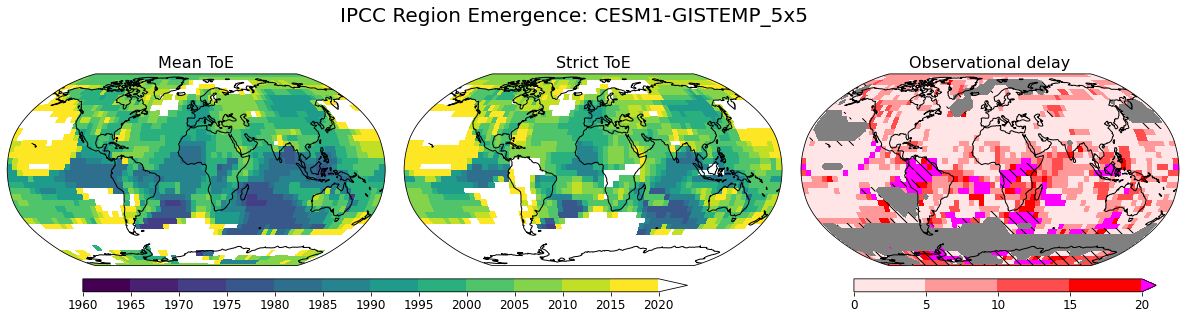

In [38]:
# User set-up
data  = spatial_box[0]
obs = 'GISTEMP_5x5' # HadCRUT
model = 'CESM1'

out = plot_spatial_toe_and_delay(data=data,obs=obs,model=model)

CPU times: user 23.8 s, sys: 276 ms, total: 24.1 s
Wall time: 25.9 s


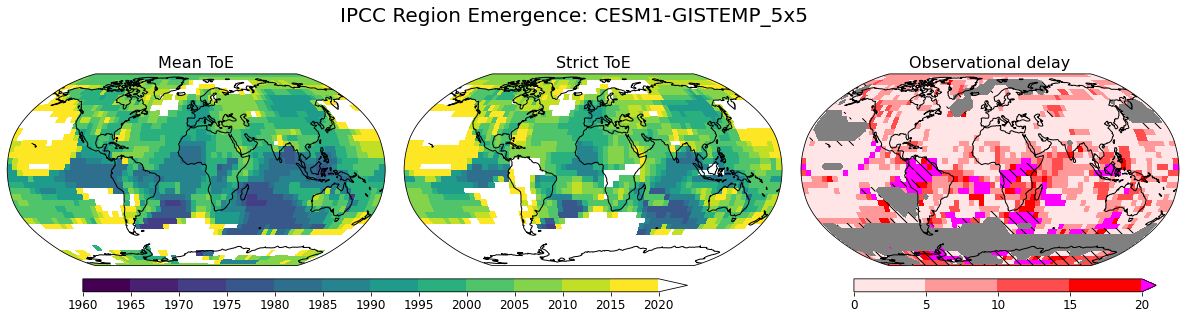

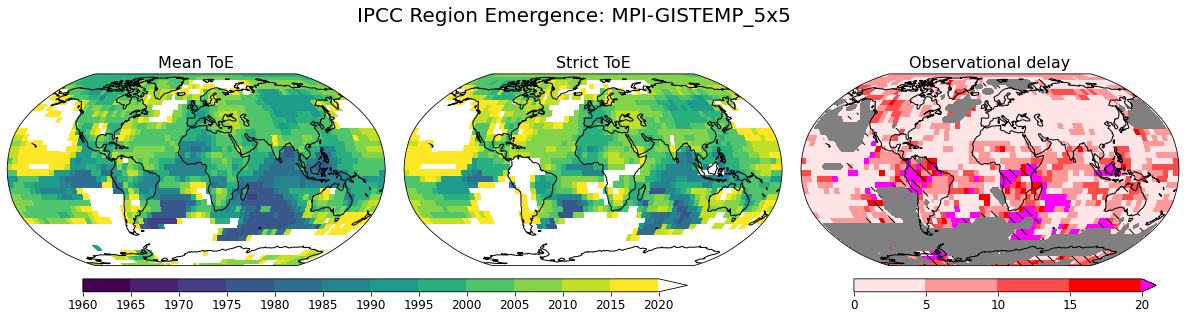

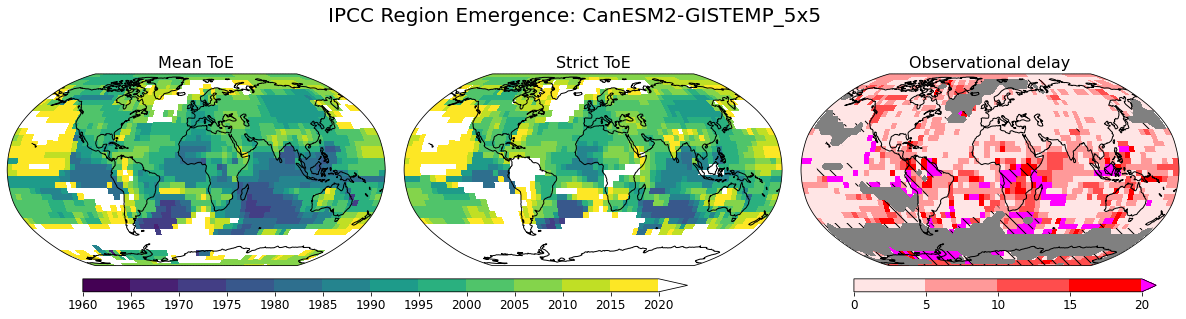

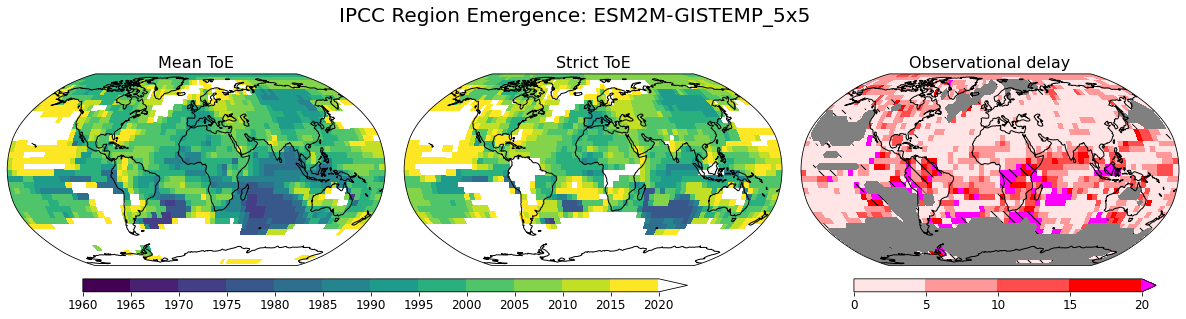

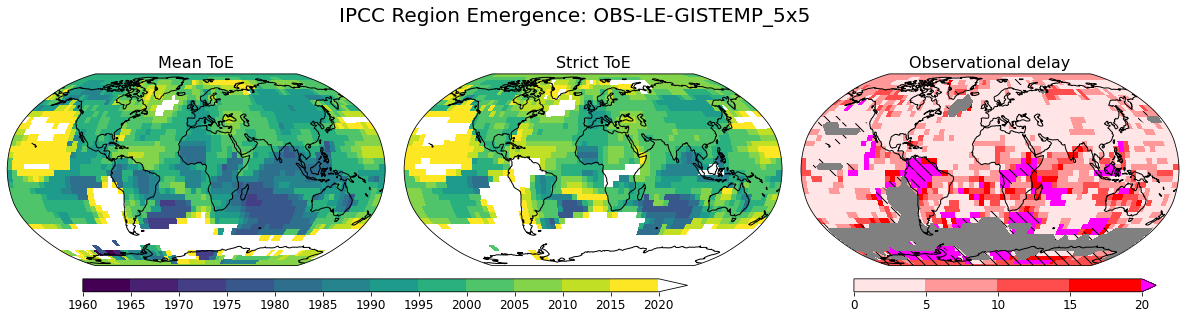

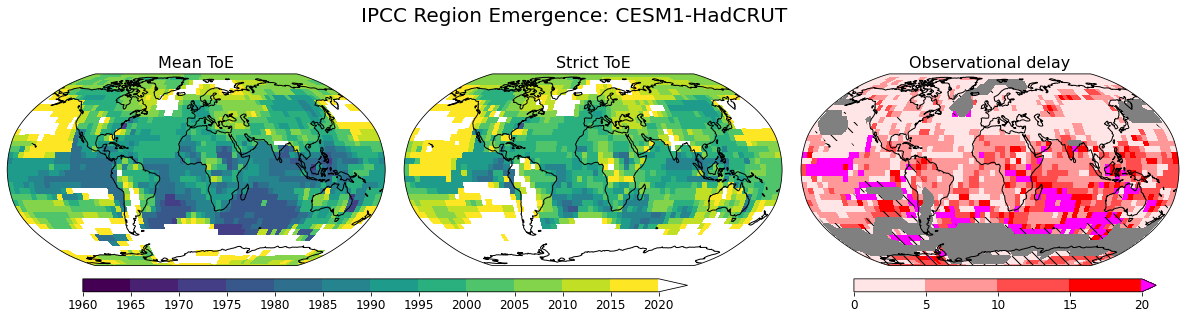

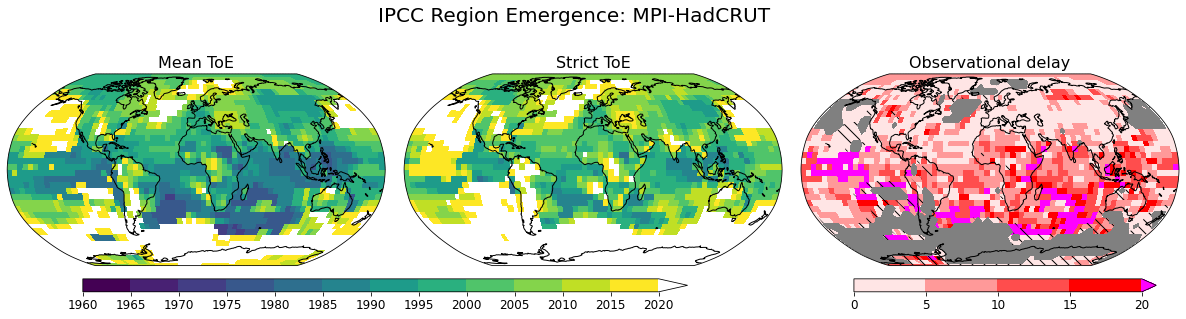

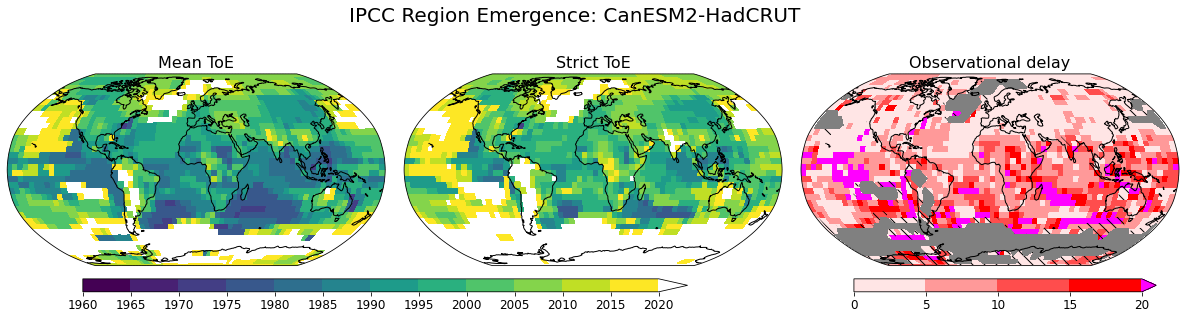

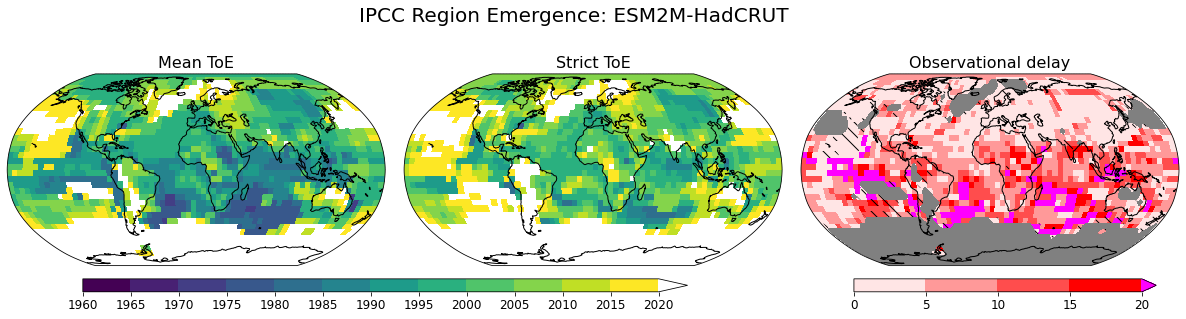

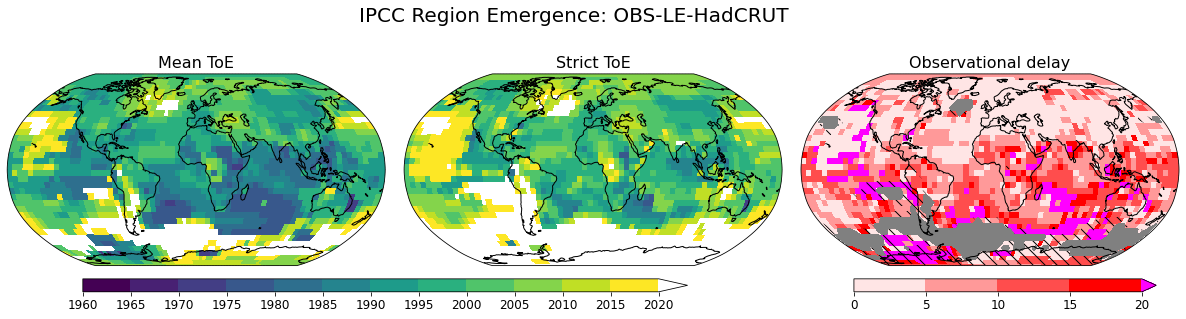

In [39]:
%%time

for _obs in regional_masked_da.obs:
        
    for _model in regional_masked_da.model:
        
        out_fig = plot_spatial_toe_and_delay(spatial_box[0],obs=_obs.values,model=_model.values)
        
        to_png(file=out_fig,filename='draft2_ToE_spatialmap_%s_%s' % (_obs.values,_model.values),dpi=300,ext='png',bbox_inches='tight')        

This is confusing to me. The regional delays are small in HadCRUT, but the spatial delays are large. So this seems to imply that there is low spatial correlation in the data, such that averaging effectively removes the observational noise and the delay.